In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import sampler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from helper_data import get_dataloaders_mnist
from helper_train import train_autoencoder_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images, plot_generated_images_new, plot_brand_new_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_latent_space_with_labels_AE
from helper_evaluate import compute_epoch_loss_autoencoder
from helper_evaluate import compute_epoch_loss_VAE

In [3]:
import time
import pandas as pd
import numpy as np
import random

In [4]:
###############################################
# SET SETTINGS 
###############################################

# Hyperparameters
RANDOM_SEED = 81962
LEARNING_RATE = 0.0005
BATCH_SIZE = 64 # do not set bigger? https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [5]:
# NOT SURE NEED TO RUN set_deterministic?
set_all_seeds(RANDOM_SEED)

In [6]:
train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    validation_fraction=0.25)

In [7]:
# Separately, include a dataset for calculating a smaller subset for performance, IF NEEDED
# This is not necessary though. The model.eval() step is quite fast
# Additionally use perf_loader to do plotting easier etc. Picking a larger batch size here as a result

perf_loader = datasets.MNIST(root='./data',
                             train=True,
                             transform=transforms.ToTensor())

# grab 5k from this dataset for calc loss!
perf_indices = torch.randint(0, 60000, (5000,))
perf_sampler = SubsetRandomSampler(perf_indices)
perf_loader = DataLoader(dataset=perf_loader,
                         batch_size = 250, # SAMPLE WITH LARGER BATCH
                         num_workers=1,
                         sampler=perf_sampler)

In [8]:
# Confirm length of the loader
len(perf_loader)*250 # APPROXIMATELY 5000 (a little more b/c need to ceiling)

5000

In [9]:
# Checking the dataset
print('Training Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
print('\nTest Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break    

# NOTE -- 4D tensor. [# batch, # channel, # row(?), # column(?)]

Training Set:
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])
tensor([1, 9, 6, 5, 8, 5, 3, 2, 8, 7])

Test Set:
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


In [10]:
# approx 45k images in training set (if use valid set)
print(len(train_loader)*BATCH_SIZE)

# approx 10k images in test set
print(len(test_loader)*BATCH_SIZE)

44992
10048


<br>

## AE Model Structure

In [11]:
#############################################################
# This AE model represents a 2-D latent layer for plotting
#############################################################

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #784
                # INPUT CHANNEL TO OUTPUT CHANNEL
                nn.Conv2d(1, 8, stride=(1, 1), kernel_size=(3, 3), padding=1), 
                nn.LeakyReLU(0.01),
                nn.Conv2d(8, 16, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(16, 16, stride=(1, 1), kernel_size=(3, 3), padding=1), # HERE --> M2 = 56
                nn.Flatten(), # Batch x M2 x M2 --> Batch x M2^2 --> Batch x M3
                nn.Linear(3136, 2) # this 2-D layer represents our final encoded "latent space"
        )
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 16, 14, 14), # defined outside the AutoEncoder class
                # ENSURE IT IS FLIPPED ORDER-WISE --> a -> b -> c -> c_T -> b_t -> a_T
                nn.ConvTranspose2d(16, 16, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, 8, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(8, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28. # defined outside the AutoEncoder class
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape)
        x = self.decoder(x)
        return x

<br>

## AE Model Training

In [201]:
# testing the train_loader, what is in here
it = iter(train_loader)

In [ ]:
# testing train_loader, can use "next"
nextone = next(it)
nextone[0].shape
nextone[1]

In [204]:
# THIS WILL RESET THE autoencoder model
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [205]:
# for batch_idx, (features, _) in enumerate(train_loader):
#     features = features.to(DEVICE)
#     # FORWARD AND BACK PROP
#     logits = model(features)
    
#     break

In [206]:
loss_fn = F.mse_loss
logging_interval=100
skip_epoch_stats=False
save_model=None
NUM_EPOCHS = 20
DEVICE = 'cpu'
                
log_dict = {'valid_loss_per_batch': [],
            'valid_loss_per_epoch': []}

start_time = time.time()
for epoch in range(NUM_EPOCHS):

    model.train()
    for batch_idx, (features, _) in enumerate(train_loader):
        features = features.to(DEVICE)

        # FORWARD PROP
        logits = model(features)
        loss = loss_fn(logits, features)
        optimizer.zero_grad()

        # BACKWARD PROP
        loss.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        log_dict['valid_loss_per_batch'].append(loss.item())

        if not batch_idx % logging_interval: # do we want to log progress run of any batch? if so, what frequency?
            print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                  % (epoch+1, NUM_EPOCHS, batch_idx,
                      len(train_loader), loss))

    if not skip_epoch_stats:
        model.eval()

        with torch.set_grad_enabled(False):  # save memory during inference
            # let's compute validation loss instead, since we split data that way
            valid_loss = compute_epoch_loss_autoencoder(
                model, valid_loader, loss_fn, DEVICE)
            print('***Epoch: %03d/%03d | Loss: %.3f' % (
                  epoch+1, NUM_EPOCHS, valid_loss))
            log_dict['valid_loss_per_epoch'].append(valid_loss.item())
    
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    # SAVE INTERMEDIATE models to see our training progress. Epoch 1, Epoch Half, Epoch Final
    if np.isin(epoch + 1, [1, int(NUM_EPOCHS/2), NUM_EPOCHS]) == True:
        mdl_name = './Model Files/ae_mnist_v1_epoch_'+ str(epoch+1) + '.pt'
        # https://stackoverflow.com/questions/59095824/what-is-the-difference-between-pt-pth-and-pwf-extentions-in-pytorch
        torch.save(model.state_dict(), mdl_name)
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Batch 0000/0703 | Loss: 0.2900
Epoch: 001/020 | Batch 0100/0703 | Loss: 0.0770
Epoch: 001/020 | Batch 0200/0703 | Loss: 0.0668
Epoch: 001/020 | Batch 0300/0703 | Loss: 0.0615
Epoch: 001/020 | Batch 0400/0703 | Loss: 0.0620
Epoch: 001/020 | Batch 0500/0703 | Loss: 0.0593
Epoch: 001/020 | Batch 0600/0703 | Loss: 0.0559
Epoch: 001/020 | Batch 0700/0703 | Loss: 0.0564
***Epoch: 001/020 | Loss: 45.735
Time elapsed: 4.63 min
Epoch: 002/020 | Batch 0000/0703 | Loss: 0.0553
Epoch: 002/020 | Batch 0100/0703 | Loss: 0.0630
Epoch: 002/020 | Batch 0200/0703 | Loss: 0.0565
Epoch: 002/020 | Batch 0300/0703 | Loss: 0.0586
Epoch: 002/020 | Batch 0400/0703 | Loss: 0.0615
Epoch: 002/020 | Batch 0500/0703 | Loss: 0.0521
Epoch: 002/020 | Batch 0600/0703 | Loss: 0.0576
Epoch: 002/020 | Batch 0700/0703 | Loss: 0.0552
***Epoch: 002/020 | Loss: 43.033
Time elapsed: 9.66 min
Epoch: 003/020 | Batch 0000/0703 | Loss: 0.0511
Epoch: 003/020 | Batch 0100/0703 | Loss: 0.0593
Epoch: 003/020 | Batch 0

Epoch: 019/020 | Batch 0600/0703 | Loss: 0.0457
Epoch: 019/020 | Batch 0700/0703 | Loss: 0.0450
***Epoch: 019/020 | Loss: 36.081
Time elapsed: 95.26 min
Epoch: 020/020 | Batch 0000/0703 | Loss: 0.0495
Epoch: 020/020 | Batch 0100/0703 | Loss: 0.0479
Epoch: 020/020 | Batch 0200/0703 | Loss: 0.0518
Epoch: 020/020 | Batch 0300/0703 | Loss: 0.0512
Epoch: 020/020 | Batch 0400/0703 | Loss: 0.0463
Epoch: 020/020 | Batch 0500/0703 | Loss: 0.0517
Epoch: 020/020 | Batch 0600/0703 | Loss: 0.0504
Epoch: 020/020 | Batch 0700/0703 | Loss: 0.0444
***Epoch: 020/020 | Loss: 36.100
Time elapsed: 100.38 min
Total Training Time: 100.39 min


In [207]:
len(valid_loader)

235

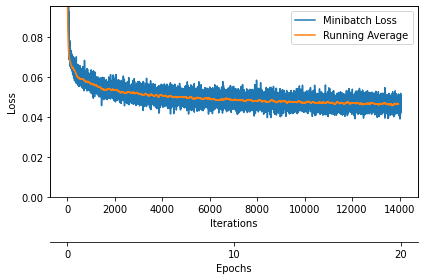

In [212]:
### Plot Model Performance 

loss_plot = plot_training_loss(log_dict['valid_loss_per_batch'], NUM_EPOCHS)

<br>

## Evaluating Model / Looking Deeper
NOTE - this AE model uses a 2-dimensional latent space of easier plotting/visualization!

In [12]:
PATH = './Model Files/ae_mnist_v1_epoch_20.pt'

ae1 = AutoEncoder()
ae1.load_state_dict(torch.load(PATH))

<All keys matched successfully>

torch.Size([10, 1, 28, 28])


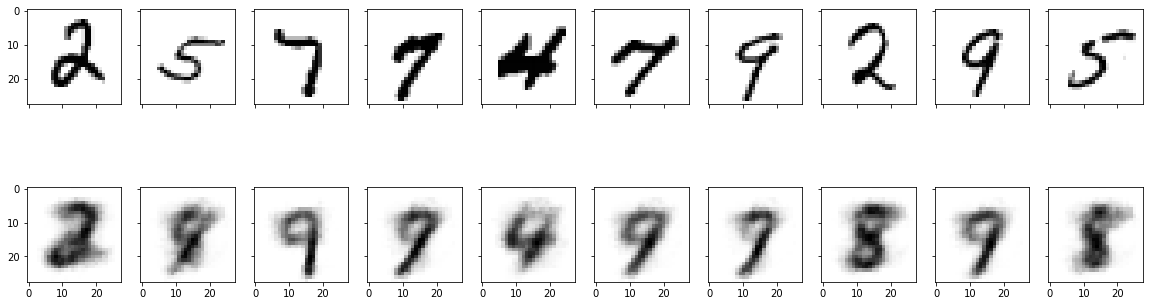

In [13]:
################################################
# Plot reproduced images using the AE
################################################

plot_generated_images_new(data_loader = perf_loader, model = ae1, device = DEVICE, figsize=(20, 6), 
                          n_images=10, plot_num = None, modeltype = 'autoencoder', fixed_idx = False)

In [19]:
################################################
# Plot specific numbers from our AE
# This takes a specific number for reconstruction
################################################

torch.Size([10, 1, 28, 28])


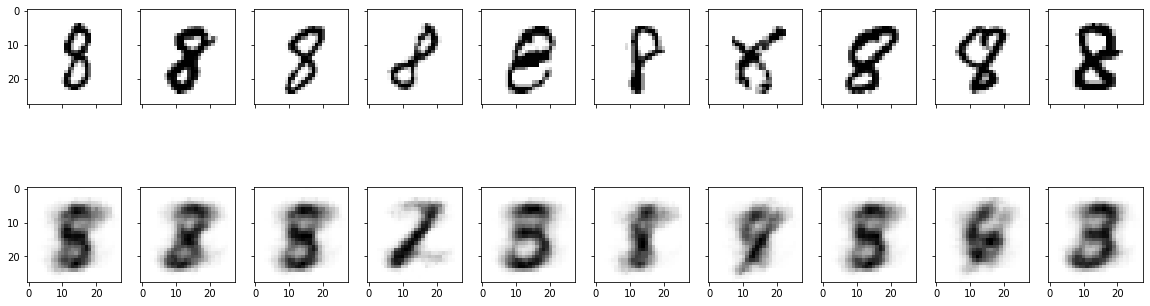

In [14]:
plot_generated_images_new(data_loader = perf_loader, model = ae1, device = DEVICE, figsize=(20, 6), 
                          n_images=10, plot_num = 8, modeltype = 'autoencoder', fixed_idx = False)

torch.Size([10, 1, 28, 28])


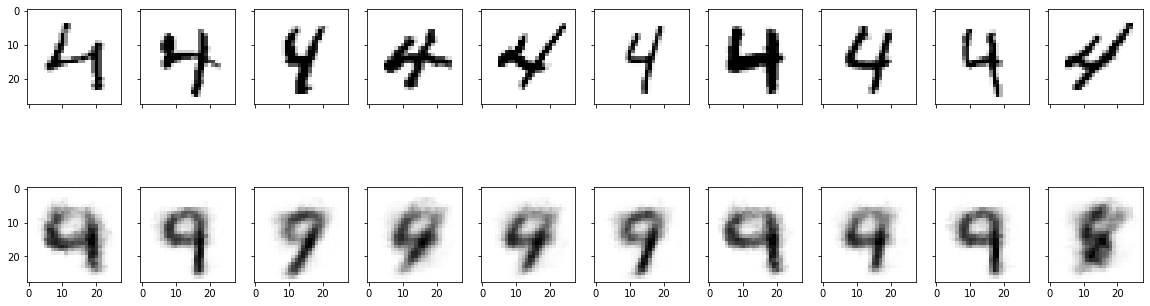

In [16]:
plot_generated_images_new(data_loader = perf_loader, model = ae1, device = DEVICE, figsize=(20, 6), 
                          n_images=10, plot_num = 4, modeltype = 'autoencoder', fixed_idx = False)

torch.Size([10, 1, 28, 28])


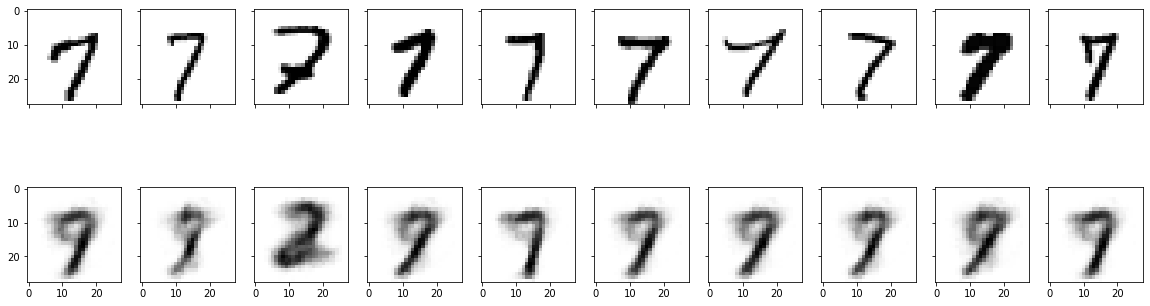

In [17]:
plot_generated_images_new(data_loader = perf_loader, model = ae1, device = DEVICE, figsize=(20, 6), 
                          n_images=10, plot_num = 7, modeltype = 'autoencoder', fixed_idx = True)

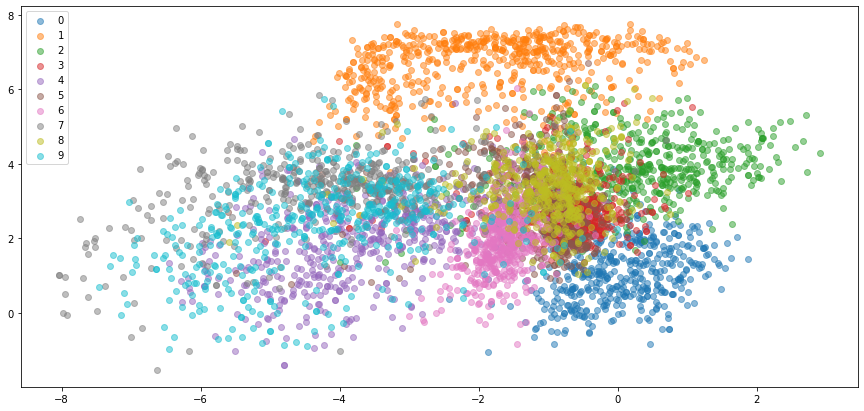

In [18]:
################################################
# Plot 'latent space' of images using the AE
################################################

plot_latent_space_with_labels_AE(
    num_classes=10,
    data_loader=perf_loader,
    model=ae1, 
    device=DEVICE,
    FIGSIZE = (15, 7))

plt.legend()
plt.show()

<br>

## VAE Model Structure

In [19]:
##############################################################################
### This VAE model represents a 2-D latent layer for plotting
##############################################################################

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                # INPUT CHANNEL TO OUTPUT CHANNEL
                nn.Conv2d(1, 8, stride=(1, 1), kernel_size=(3, 3), padding=1), 
                nn.LeakyReLU(0.01),
                nn.Conv2d(8, 16, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(16, 16, stride=(1, 1), kernel_size=(3, 3), padding=1), # HERE --> M2 = 56
                nn.Flatten(), # Batch x M2 x M2 --> Batch x M2^2 --> Batch x M3
        )    
        
        self.z_mean = torch.nn.Linear(3136, 2)
        self.z_log_var = torch.nn.Linear(3136, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 16, 14, 14), # defined outside the AutoEncoder class
                # ENSURE IT IS FLIPPED ORDER-WISE --> a -> b -> c -> c_T -> b_t -> a_T
                nn.ConvTranspose2d(16, 16, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, 8, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(8, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28. # defined outside the AutoEncoder class
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    
    # NOTE -- for reparameterize, we basically parameterize to N(z_mu, exp(z_log_var))
    def reparameterize(self, z_mu, z_log_var):
#         eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device()) # .get_device() DOES NOT WORK. ASSUME CPU
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cpu') 
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

<br>

## VAE Model Training

In [12]:
# testing the train_loader, what is in here
it = iter(train_loader)

In [13]:
# testing train_loader, can use "next"
nextone = next(it)
nextone[0].shape
nextone[1]

tensor([5, 2, 6, 7, 1, 2, 2, 1, 2, 4, 1, 2, 3, 8, 9, 1, 1, 1, 9, 2, 7, 4, 8, 3,
        5, 9, 1, 4, 2, 0, 8, 2, 0, 9, 7, 0, 1, 3, 6, 6, 7, 4, 8, 3, 8, 1, 4, 9,
        1, 9, 9, 1, 3, 7, 6, 7, 9, 0, 1, 8, 1, 9, 5, 9])

In [14]:
# vae_model = VAE()
# vae_model.train()

# for batch_idx, (features, _) in enumerate(train_loader):
#     features = features.to(DEVICE)
    
#     # FORWARD AND BACK PROP
#     encoded, z_mean, z_log_var, decoded = vae_model(features)
#     break

In [22]:
# THIS WILL RESET THE VAE model
vae_model = VAE()
optimizer = torch.optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)

In [17]:
loss_fn = F.mse_loss
logging_interval=100
skip_epoch_stats=False
save_model=None
NUM_EPOCHS = 40
reconstruction_term_weight=1
DEVICE = 'cpu'

log_dict_vae = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}


start_time = time.time()
for epoch in range(NUM_EPOCHS):

    vae_model.train()
    for batch_idx, (features, _) in enumerate(train_loader):

        features = features.to(DEVICE)

        # FORWARD AND BACK PROP
        encoded, z_mean, z_log_var, decoded = vae_model(features)

        # total loss = reconstruction loss + KL divergence
        #kl_divergence = (0.5 * (z_mean**2 + 
        #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
        kl_div = -0.5 * torch.sum(1 + z_log_var 
                                  - z_mean**2 
                                  - torch.exp(z_log_var), 
                                  axis=1) # sum over latent dimension

        batchsize = kl_div.size(0)
        kl_div = kl_div.mean() # average over batch dimension

        pixelwise = loss_fn(decoded, features, reduction='none')
        pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
        pixelwise = pixelwise.mean() # average over batch dimension

        loss = reconstruction_term_weight*pixelwise + kl_div

        optimizer.zero_grad()

        loss.backward()

        # UPDATE VAE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        log_dict_vae['train_combined_loss_per_batch'].append(loss.item())
        log_dict_vae['train_reconstruction_loss_per_batch'].append(pixelwise.item())
        log_dict_vae['train_kl_loss_per_batch'].append(kl_div.item())

        if not batch_idx % logging_interval:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                  % (epoch+1, NUM_EPOCHS, batch_idx,
                      len(train_loader), loss))

    if not skip_epoch_stats:
        vae_model.eval()

        with torch.set_grad_enabled(False):  # save memory during inference

            train_loss = compute_epoch_loss_VAE(
                vae_model, train_loader, loss_fn, DEVICE)
            print('***Epoch: %03d/%03d | Loss: %.3f' % (
                  epoch+1, NUM_EPOCHS, train_loss))
            log_dict_vae['train_combined_loss_per_epoch'].append(train_loss.item())

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    # SAVE INTERMEDIATE VAE models to see our training progress. Epoch 1, Epoch Half, Epoch Final
    if np.isin(epoch + 1, [1, int(NUM_EPOCHS/2), NUM_EPOCHS]) == True:
        mdl_name = './Model Files/vae_mnist_v1_epoch_'+ str(epoch+1) + '.pt'
        # https://stackoverflow.com/questions/59095824/what-is-the-difference-between-pt-pth-and-pwf-extentions-in-pytorch
        torch.save(vae_model.state_dict(), mdl_name)

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/040 | Batch 0000/0703 | Loss: 234.7588
Epoch: 001/040 | Batch 0100/0703 | Loss: 72.3688
Epoch: 001/040 | Batch 0200/0703 | Loss: 55.9007
Epoch: 001/040 | Batch 0300/0703 | Loss: 53.1505
Epoch: 001/040 | Batch 0400/0703 | Loss: 50.3840
Epoch: 001/040 | Batch 0500/0703 | Loss: 51.1221
Epoch: 001/040 | Batch 0600/0703 | Loss: 49.9074
Epoch: 001/040 | Batch 0700/0703 | Loss: 49.5087
***Epoch: 001/040 | Loss: 45.574
Time elapsed: 1.61 min
Epoch: 002/040 | Batch 0000/0703 | Loss: 44.2479
Epoch: 002/040 | Batch 0100/0703 | Loss: 49.7200
Epoch: 002/040 | Batch 0200/0703 | Loss: 48.9077
Epoch: 002/040 | Batch 0300/0703 | Loss: 49.4218
Epoch: 002/040 | Batch 0400/0703 | Loss: 45.2588
Epoch: 002/040 | Batch 0500/0703 | Loss: 45.4781
Epoch: 002/040 | Batch 0600/0703 | Loss: 47.9151
Epoch: 002/040 | Batch 0700/0703 | Loss: 45.1598
***Epoch: 002/040 | Loss: 42.587
Time elapsed: 3.26 min
Epoch: 003/040 | Batch 0000/0703 | Loss: 46.4697
Epoch: 003/040 | Batch 0100/0703 | Loss: 43.7260
Epoch

Epoch: 019/040 | Batch 0300/0703 | Loss: 39.3297
Epoch: 019/040 | Batch 0400/0703 | Loss: 40.3247
Epoch: 019/040 | Batch 0500/0703 | Loss: 38.4587
Epoch: 019/040 | Batch 0600/0703 | Loss: 41.5075
Epoch: 019/040 | Batch 0700/0703 | Loss: 39.8994
***Epoch: 019/040 | Loss: 35.996
Time elapsed: 33.13 min
Epoch: 020/040 | Batch 0000/0703 | Loss: 40.3694
Epoch: 020/040 | Batch 0100/0703 | Loss: 42.0942
Epoch: 020/040 | Batch 0200/0703 | Loss: 40.8803
Epoch: 020/040 | Batch 0300/0703 | Loss: 36.6890
Epoch: 020/040 | Batch 0400/0703 | Loss: 42.1932
Epoch: 020/040 | Batch 0500/0703 | Loss: 42.1798
Epoch: 020/040 | Batch 0600/0703 | Loss: 39.7749
Epoch: 020/040 | Batch 0700/0703 | Loss: 38.8583
***Epoch: 020/040 | Loss: 35.871
Time elapsed: 34.99 min
Epoch: 021/040 | Batch 0000/0703 | Loss: 37.4999
Epoch: 021/040 | Batch 0100/0703 | Loss: 41.0982
Epoch: 021/040 | Batch 0200/0703 | Loss: 39.8186
Epoch: 021/040 | Batch 0300/0703 | Loss: 38.9518
Epoch: 021/040 | Batch 0400/0703 | Loss: 40.2189
Epoc

Epoch: 037/040 | Batch 0600/0703 | Loss: 41.0573
Epoch: 037/040 | Batch 0700/0703 | Loss: 39.2516
***Epoch: 037/040 | Loss: 35.247
Time elapsed: 66.45 min
Epoch: 038/040 | Batch 0000/0703 | Loss: 41.5905
Epoch: 038/040 | Batch 0100/0703 | Loss: 42.1459
Epoch: 038/040 | Batch 0200/0703 | Loss: 38.6499
Epoch: 038/040 | Batch 0300/0703 | Loss: 37.1451
Epoch: 038/040 | Batch 0400/0703 | Loss: 41.1693
Epoch: 038/040 | Batch 0500/0703 | Loss: 40.5784
Epoch: 038/040 | Batch 0600/0703 | Loss: 36.7894
Epoch: 038/040 | Batch 0700/0703 | Loss: 38.2255
***Epoch: 038/040 | Loss: 35.127
Time elapsed: 68.31 min
Epoch: 039/040 | Batch 0000/0703 | Loss: 41.1474
Epoch: 039/040 | Batch 0100/0703 | Loss: 37.1841
Epoch: 039/040 | Batch 0200/0703 | Loss: 39.4579
Epoch: 039/040 | Batch 0300/0703 | Loss: 39.6659
Epoch: 039/040 | Batch 0400/0703 | Loss: 38.5532
Epoch: 039/040 | Batch 0500/0703 | Loss: 36.0987
Epoch: 039/040 | Batch 0600/0703 | Loss: 39.0333
Epoch: 039/040 | Batch 0700/0703 | Loss: 37.9976
***E

<br>

## Deeper Look at VAEs
Again -- model has a latent space in 2-D ONLY for plotting

In [20]:
PATH = './Model Files/vae_mnist_v1_epoch_40.pt'

vae1 = VAE() # LOAD FROM ABOVE FIRST IF NEEDED
vae1.load_state_dict(torch.load(PATH))

<All keys matched successfully>

torch.Size([10, 1, 28, 28])


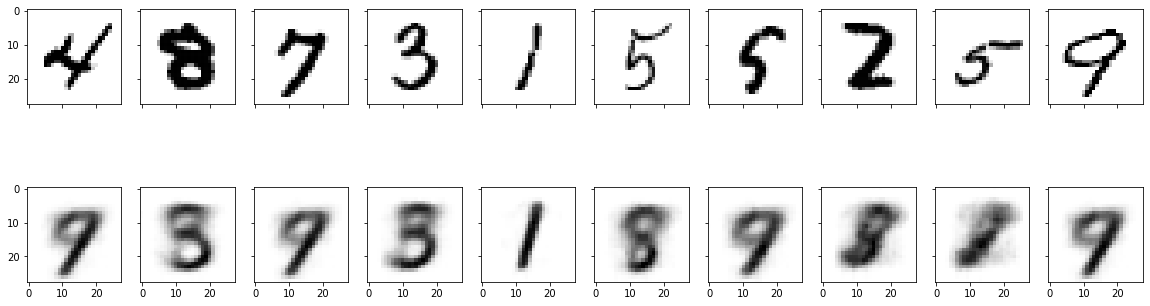

In [21]:
################################################
# Plot reproduced images using the VAE
################################################

plot_generated_images_new(data_loader = perf_loader, model = vae1, device = DEVICE, 
                          figsize=(20, 6), n_images=10, plot_num = None, modeltype='VAE')

In [ ]:
#####################################################
##### Plot specific numbers from generated VAE
# These are actually generated numbers!
# Every time, will see different digits each time
#####################################################

torch.Size([10, 1, 28, 28])


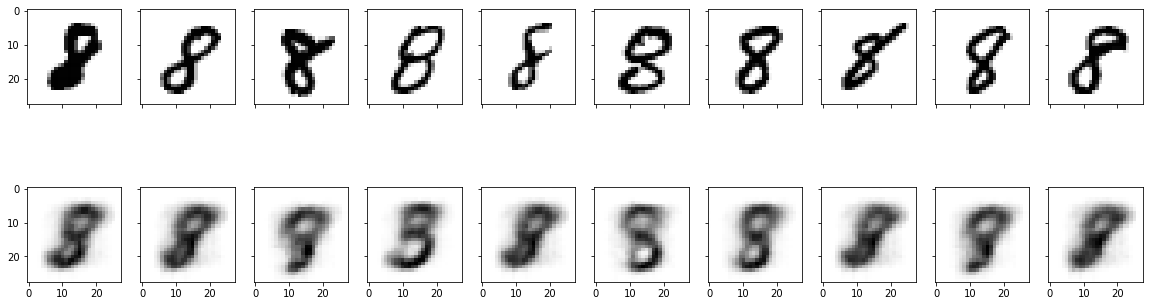

In [22]:
plot_generated_images_new(data_loader = perf_loader, model = vae1, device = DEVICE, 
                          figsize=(20, 6), n_images=10, plot_num = 8, modeltype='VAE')

torch.Size([10, 1, 28, 28])


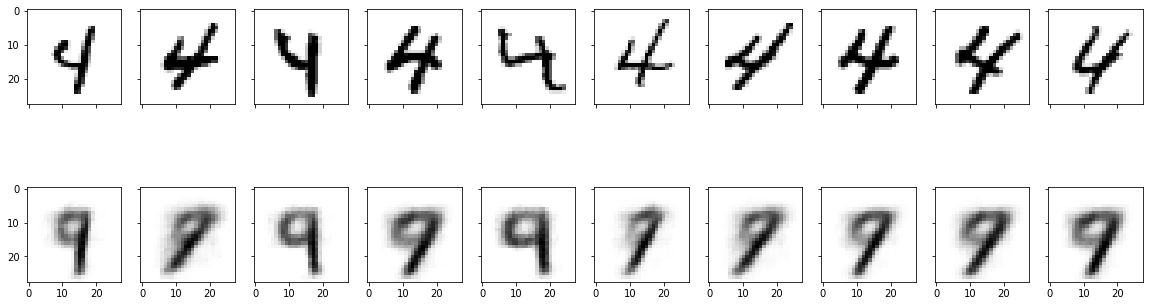

In [27]:
plot_generated_images_new(data_loader = perf_loader, model = vae1, device = DEVICE, 
                          figsize=(20, 6), n_images=10, plot_num = 4, modeltype='VAE')

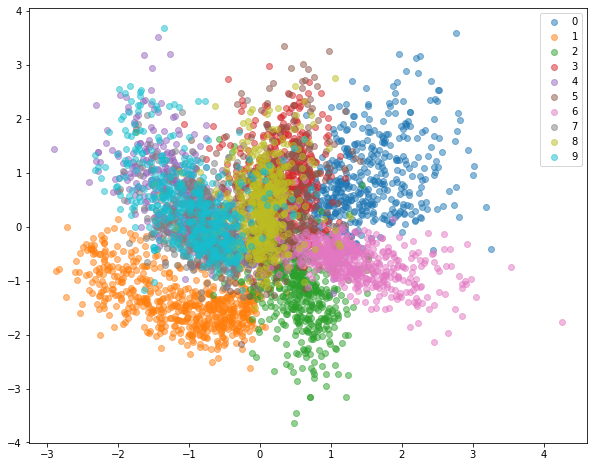

In [25]:
################################################
# Plot 'latent space' of images using the VAE
################################################

plot_latent_space_with_labels(
    num_classes=10,
    data_loader=perf_loader,
    encoding_fn=vae1.encoding_fn, # this actually DRAWS A RANDOM SAMPLE FROM EACH DISTRIBUTION
    device=DEVICE,
    FIGSIZE = (10, 8))

plt.legend()
plt.show()

<br>

## Latent Spaces Provide a (Statistically) Valid Way of Generating New Images

In [192]:
################################################
# Plot completely new images using latent space
################################################

In [34]:
# import importlib
# import sys
# importlib.reload(sys.modules['helper_plotting'])
# from helper_plotting import plot_brand_new_images

Used torch.Size([33, 1, 28, 28]) observations to get the latent mean / var
Generated torch.Size([100, 1, 28, 28]) new observations


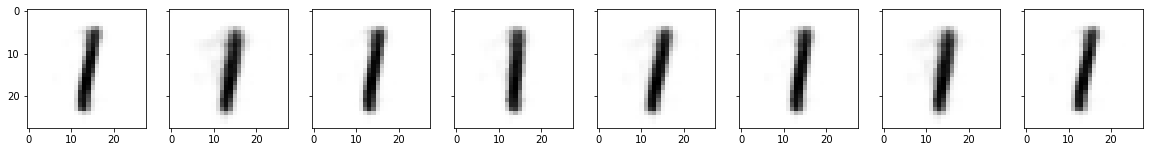

In [30]:
plot_brand_new_images(data_loader = perf_loader, model = vae1, device = DEVICE, 
                      figsize=(20, 6), n_images = 8, n_sample = -1, 
                      plot_num = 1)

Used torch.Size([26, 1, 28, 28]) observations to get the latent mean / var
Generated torch.Size([100, 1, 28, 28]) new observations


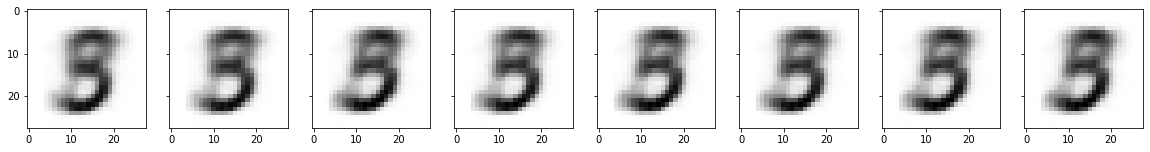

In [31]:
plot_brand_new_images(data_loader = perf_loader, model = vae1, device = DEVICE, 
                      figsize=(20, 6), n_images = 8, n_sample = -1, 
                      plot_num = 3)

<br>

## How Important is the Latent Space?
We have been using 2 dimensions until now for demo-ing and visualization only

In [31]:
##############################################################################
### This VAE model represents a 4-D latent layer, can probably still plot
##############################################################################

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class VAE2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                # INPUT CHANNEL TO OUTPUT CHANNEL
                nn.Conv2d(1, 8, stride=(1, 1), kernel_size=(3, 3), padding=1), 
                nn.LeakyReLU(0.01),
                nn.Conv2d(8, 16, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(16, 16, stride=(1, 1), kernel_size=(3, 3), padding=1), # HERE --> M2 = 56
                nn.Flatten(), # Batch x M2 x M2 --> Batch x M2^2 --> Batch x M3
        )    
        
        # SIMPLY DOUBLING THE LATENT DIMENSION!
        self.z_mean = torch.nn.Linear(3136, 4)
        self.z_log_var = torch.nn.Linear(3136, 4)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(4, 3136),
                Reshape(-1, 16, 14, 14), # defined outside the AutoEncoder class
                # ENSURE IT IS FLIPPED ORDER-WISE --> a -> b -> c -> c_T -> b_t -> a_T
                nn.ConvTranspose2d(16, 16, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, 8, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(8, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28. # defined outside the AutoEncoder class
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
    
    # NOTE -- for reparameterize, we basically parameterize to N(z_mu, exp(z_log_var))
    def reparameterize(self, z_mu, z_log_var):
#         eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device()) # .get_device() DOES NOT WORK. ASSUME CPU
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cpu') 
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

<br>

## Train New VAE Model

In [48]:
# THIS WILL RESET THE VAE model
vae_model2 = VAE2()
optimizer = torch.optim.Adam(vae_model2.parameters(), lr=LEARNING_RATE)

In [49]:
################################################
#### DO NOT FORGET TO CHANGE THE MODEL SAVE FILE
################################################

loss_fn = F.mse_loss
logging_interval=100
skip_epoch_stats=False
save_model=None
NUM_EPOCHS = 40
reconstruction_term_weight=1
DEVICE = 'cpu'

log_dict_vae = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}


start_time = time.time()
for epoch in range(NUM_EPOCHS):

    vae_model2.train()
    for batch_idx, (features, _) in enumerate(train_loader):

        features = features.to(DEVICE)

        # FORWARD AND BACK PROP
        encoded, z_mean, z_log_var, decoded = vae_model2(features)

        # total loss = reconstruction loss + KL divergence
        #kl_divergence = (0.5 * (z_mean**2 + 
        #                        torch.exp(z_log_var) - z_log_var - 1)).sum()
        kl_div = -0.5 * torch.sum(1 + z_log_var 
                                  - z_mean**2 
                                  - torch.exp(z_log_var), 
                                  axis=1) # sum over latent dimension

        batchsize = kl_div.size(0)
        kl_div = kl_div.mean() # average over batch dimension

        pixelwise = loss_fn(decoded, features, reduction='none')
        pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
        pixelwise = pixelwise.mean() # average over batch dimension

        loss = reconstruction_term_weight*pixelwise + kl_div

        optimizer.zero_grad()

        loss.backward()

        # UPDATE VAE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        log_dict_vae['train_combined_loss_per_batch'].append(loss.item())
        log_dict_vae['train_reconstruction_loss_per_batch'].append(pixelwise.item())
        log_dict_vae['train_kl_loss_per_batch'].append(kl_div.item())

        if not batch_idx % logging_interval:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                  % (epoch+1, NUM_EPOCHS, batch_idx,
                      len(train_loader), loss))

    if not skip_epoch_stats:
        vae_model2.eval()

        with torch.set_grad_enabled(False):  # save memory during inference

            train_loss = compute_epoch_loss_VAE(
                vae_model2, train_loader, loss_fn, DEVICE)
            print('***Epoch: %03d/%03d | Loss: %.3f' % (
                  epoch+1, NUM_EPOCHS, train_loss))
            log_dict_vae['train_combined_loss_per_epoch'].append(train_loss.item())

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    # SAVE INTERMEDIATE VAE models to see our training progress. Epoch 1, Epoch Half, Epoch Final
    if np.isin(epoch + 1, [1, int(NUM_EPOCHS/2), NUM_EPOCHS]) == True:
        mdl_name = './Model Files/vae_mnist_v2_epoch_'+ str(epoch+1) + '.pt'
        # https://stackoverflow.com/questions/59095824/what-is-the-difference-between-pt-pth-and-pwf-extentions-in-pytorch
        torch.save(vae_model2.state_dict(), mdl_name)

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/040 | Batch 0000/0703 | Loss: 234.8652
Epoch: 001/040 | Batch 0100/0703 | Loss: 67.2010
Epoch: 001/040 | Batch 0200/0703 | Loss: 55.3882
Epoch: 001/040 | Batch 0300/0703 | Loss: 48.7797
Epoch: 001/040 | Batch 0400/0703 | Loss: 47.6566
Epoch: 001/040 | Batch 0500/0703 | Loss: 45.4536
Epoch: 001/040 | Batch 0600/0703 | Loss: 42.2918
Epoch: 001/040 | Batch 0700/0703 | Loss: 45.5391
***Epoch: 001/040 | Loss: 38.576
Time elapsed: 1.33 min
Epoch: 002/040 | Batch 0000/0703 | Loss: 43.7781
Epoch: 002/040 | Batch 0100/0703 | Loss: 45.5747
Epoch: 002/040 | Batch 0200/0703 | Loss: 40.3397
Epoch: 002/040 | Batch 0300/0703 | Loss: 41.0331
Epoch: 002/040 | Batch 0400/0703 | Loss: 39.7953
Epoch: 002/040 | Batch 0500/0703 | Loss: 40.5226
Epoch: 002/040 | Batch 0600/0703 | Loss: 40.2266
Epoch: 002/040 | Batch 0700/0703 | Loss: 40.5951
***Epoch: 002/040 | Loss: 34.382
Time elapsed: 2.62 min
Epoch: 003/040 | Batch 0000/0703 | Loss: 39.7450
Epoch: 003/040 | Batch 0100/0703 | Loss: 39.8521
Epoch

Epoch: 019/040 | Batch 0300/0703 | Loss: 33.1300
Epoch: 019/040 | Batch 0400/0703 | Loss: 33.8091
Epoch: 019/040 | Batch 0500/0703 | Loss: 33.0004
Epoch: 019/040 | Batch 0600/0703 | Loss: 33.8721
Epoch: 019/040 | Batch 0700/0703 | Loss: 36.3328
***Epoch: 019/040 | Loss: 27.801
Time elapsed: 27.29 min
Epoch: 020/040 | Batch 0000/0703 | Loss: 37.9511
Epoch: 020/040 | Batch 0100/0703 | Loss: 35.1464
Epoch: 020/040 | Batch 0200/0703 | Loss: 36.3310
Epoch: 020/040 | Batch 0300/0703 | Loss: 35.3543
Epoch: 020/040 | Batch 0400/0703 | Loss: 33.2576
Epoch: 020/040 | Batch 0500/0703 | Loss: 33.1538
Epoch: 020/040 | Batch 0600/0703 | Loss: 34.5461
Epoch: 020/040 | Batch 0700/0703 | Loss: 33.9164
***Epoch: 020/040 | Loss: 27.812
Time elapsed: 28.62 min
Epoch: 021/040 | Batch 0000/0703 | Loss: 37.6396
Epoch: 021/040 | Batch 0100/0703 | Loss: 35.5933
Epoch: 021/040 | Batch 0200/0703 | Loss: 34.9001
Epoch: 021/040 | Batch 0300/0703 | Loss: 34.8801
Epoch: 021/040 | Batch 0400/0703 | Loss: 33.0795
Epoc

Epoch: 037/040 | Batch 0600/0703 | Loss: 35.4875
Epoch: 037/040 | Batch 0700/0703 | Loss: 32.4506
***Epoch: 037/040 | Loss: 26.909
Time elapsed: 50.64 min
Epoch: 038/040 | Batch 0000/0703 | Loss: 34.6012
Epoch: 038/040 | Batch 0100/0703 | Loss: 35.0083
Epoch: 038/040 | Batch 0200/0703 | Loss: 34.9519
Epoch: 038/040 | Batch 0300/0703 | Loss: 35.4904
Epoch: 038/040 | Batch 0400/0703 | Loss: 34.0586
Epoch: 038/040 | Batch 0500/0703 | Loss: 31.3777
Epoch: 038/040 | Batch 0600/0703 | Loss: 35.0303
Epoch: 038/040 | Batch 0700/0703 | Loss: 36.2212
***Epoch: 038/040 | Loss: 27.122
Time elapsed: 51.93 min
Epoch: 039/040 | Batch 0000/0703 | Loss: 32.0146
Epoch: 039/040 | Batch 0100/0703 | Loss: 33.8104
Epoch: 039/040 | Batch 0200/0703 | Loss: 34.4053
Epoch: 039/040 | Batch 0300/0703 | Loss: 36.9869
Epoch: 039/040 | Batch 0400/0703 | Loss: 35.0540
Epoch: 039/040 | Batch 0500/0703 | Loss: 33.4852
Epoch: 039/040 | Batch 0600/0703 | Loss: 33.5873
Epoch: 039/040 | Batch 0700/0703 | Loss: 34.1811
***E

<br>

## Model Evaluation

In [32]:
PATH = './Model Files/vae_mnist_v2_epoch_40.pt'

vae2 = VAE2() # LOAD FROM ABOVE FIRST IF NEEDED
vae2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

torch.Size([10, 1, 28, 28])


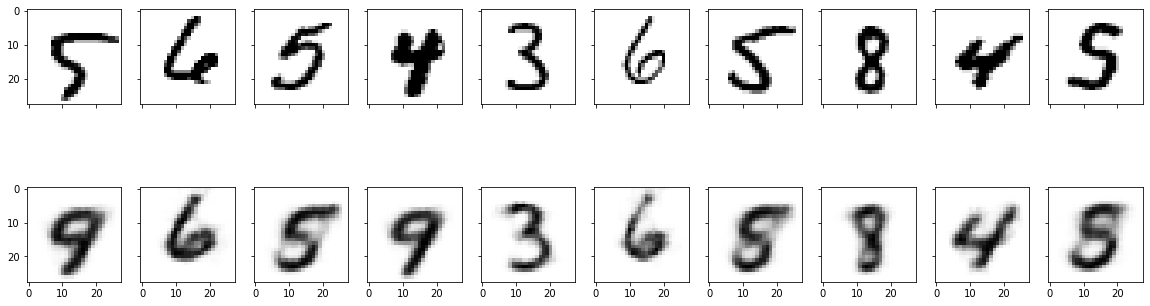

In [33]:
################################################
# Plot reproduced images using the VAE
################################################

plot_generated_images_new(data_loader = perf_loader, model = vae2, device = DEVICE, 
                          figsize=(20, 6), n_images=10, plot_num = None, modeltype='VAE')

torch.Size([10, 1, 28, 28])


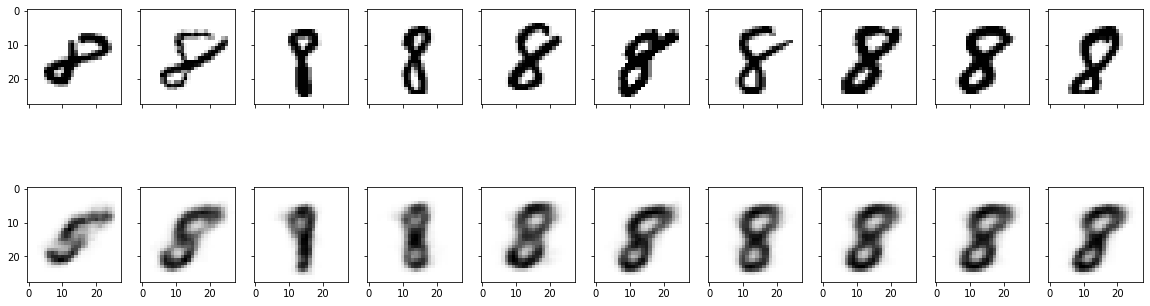

In [34]:
################################################
# Plot reproduced images using the VAE for SPECIFIC number
################################################

# 8 (YELLOW) AND 3 (RED) USED TO NOT SEPARATE
plot_generated_images_new(data_loader = perf_loader, model = vae2, device = DEVICE, 
                          figsize=(20, 6), n_images=10, plot_num = 8, modeltype='VAE')

torch.Size([10, 1, 28, 28])


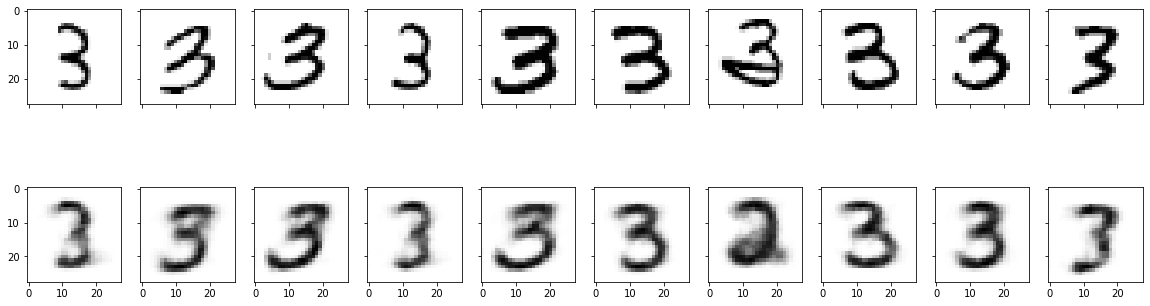

In [35]:
# NOW THEY DO
plot_generated_images_new(data_loader = perf_loader, model = vae2, device = DEVICE, 
                          figsize=(20, 6), n_images=10, plot_num = 3, modeltype='VAE')

torch.Size([10, 1, 28, 28])


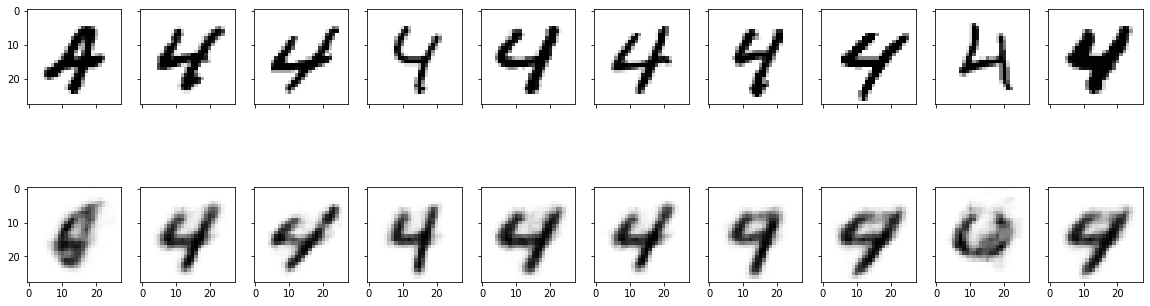

In [36]:
# 4 AND 9 ARE STILL HARD TO SEPARATE THOUGH
plot_generated_images_new(data_loader = perf_loader, model = vae2, device = DEVICE, 
                          figsize=(20, 6), n_images=10, plot_num = 4, modeltype='VAE')

<br>

## Power of the Latent Space

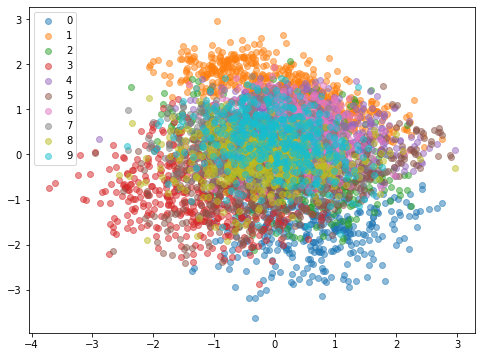

In [37]:
################################################
# Plot 'latent space' of images using the VAE
# BUT CUT IT ACROSS THE DIFFERENT AXES -- PICK THE AXES
################################################

plot_latent_space_with_labels(
    num_classes=10,
    data_loader=perf_loader,
    encoding_fn=vae2.encoding_fn, # this actually DRAWS A RANDOM SAMPLE FROM EACH DISTRIBUTION
    device=DEVICE,
    FIGSIZE = (8, 6), 
    dim1 = 1,
    dim2 = 3)

plt.legend()
plt.show()

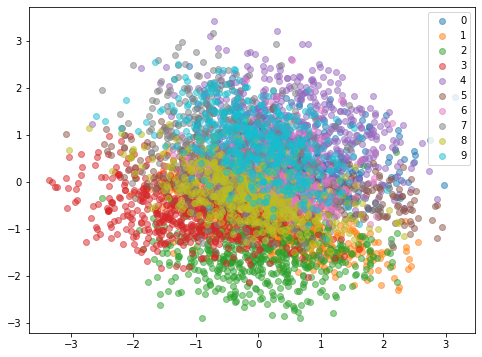

In [38]:
plot_latent_space_with_labels(
    num_classes=10,
    data_loader=perf_loader,
    encoding_fn=vae2.encoding_fn, # this actually DRAWS A RANDOM SAMPLE FROM EACH DISTRIBUTION
    device=DEVICE,
    FIGSIZE = (8, 6), 
    dim1 = 1,
    dim2 = 2)

plt.legend()
plt.show()

## A Passing Thought
AE/VAE methods are just like any another dimension reduction/reconstruction method! i.e. SVD <br>
<br>
But more powerful and flexible